### Modeling Market Risk Using Historical and Parametric Value at Risk Methods
Author : E. Delali Aggor

#### Introduction
Value at Risk (VAR) is a fairly simple but valuable risk measure that provides enables investors/traders understand the risk of loss for their investments. VaR allows financial professionals to estimate how much an investment could lose over a given period of time (for example, over a day or a month) under normal market conditions.

VaR can be calculated at different levels. It can also be used to estimate the risk of a single security or a portfolio of securities. Most commercial banks and investment firms use VaR as an estimate to understand the potential losses of their portfolios.

From a statistical point of view, confidence level is an important parameter for calculating VaR. VaR quantifies with a certain degree of confidence the maximum potential losses of a security or portfolio over period. For instance, the 95% confidence of a portfolio has VAR of 100.000 EUR in a day. This implies that there is a 95% confidence that the portfolio will not lose more than 100.000 EUR within a day.

#### Interpreting VaR
A daily VaR of 6.5% with 95% confidence implies that:

there is a 5% condfidence that your portfolio will lose 6.5% in a day.
or we have 95% confidence that our portfolio will lose 6.5% or more in a day.
Similarly: "We have a portfolio VaR of 50,000 euros over the next month at 95% confidence" This means that, with 95% confidence, we can say that the portfolio's loss will not exceed 50,000 euros in a month.

#### Estimating VaR
As a standard risk metric, various models have been put forward for estimating Var. The main categories are:

**Non-Parametric**: With this method, it is not necessary to make assumptions about the distribution of returns. The main example of this method is the Historical Simulation, in which the empirical distribution of past portfolio returns is used to estimate VaR.

**Parametric VaR** : This method first identities the portfolio returns (average or expected value, standard deviation) and their distribution before the VaR estimation. Some methods in the parametric category are the variance-covariance (VC) method and many GARCH variant methods, such as the Risk Metrics model.

**Monte Carlo Simulation**: This method makes certain assumptions about the distribution of returns. The most important semi-parametric method is the Monte Carlo simulation. This method generates random scenarios for future portfolio returns with a distribution based on certain non-linear pricing models.

In this work, we focus on the first two methods.

### Historical Simulation Method

#### 1. Collect Historical Price Data
- Obtain historical **daily closing prices** for the asset (e.g., BASF.DE).
- Ensure data is clean and free of missing values.

#### 2. Calculate Daily Returns
- Compute **daily log returns** using the formula:  
  $$
  r_t = \ln\left(\frac{P_t}{P_{t-1}}\right)
  $$
- Store these returns for analysis.

#### 3. Sort the Return Series
- Sort the list of daily returns in **ascending order** (from worst to best).

#### 4. Determine the Confidence Level
- Choose a confidence level for VaR (e.g., **95% or 99%**).

#### 5. Compute the VaR Percentile
- For a **95% confidence level**, locate the **5th percentile** of sorted returns.
- For a **99% confidence level**, locate the **1st percentile**.

#### 6. Extract the VaR Value
- The VaR is the **absolute value** of the return at the selected percentile.
- This represents the maximum expected loss at that confidence level over the time horizon.

#### 7. Interpret VaR
- The calculated VaR indicates:  
  *“There is a X% confidence that daily losses will not exceed Y amount.”*

---

## Steps to Calculate Historical CVaR (Conditional VaR / Expected Shortfall)

#### 1. Follow Steps 1 to 5 from Historical VaR
- Compute log returns, sort them, and determine the VaR percentile.

#### 2. Identify the Tail Losses Beyond VaR
- Extract **all returns that are worse (≤ VaR threshold)**.

#### 3. Compute the Expected Shortfall (CVaR)
- Calculate the **average of these worst-case returns**.
- Take the absolute value to get CVaR.

#### 4. Interpret CVaR
- CVaR represents the **average expected loss in the tail beyond VaR**.
- It's a more risk-sensitive measure than VaR.

In [18]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Define the stock and date range
ticker = 'BAS.DE'
start_date = '2020-01-01'
end_date = '2024-12-31'

# Download historical daily data
data = yf.download(ticker, start=start_date, end=end_date)

# Show first few rows
data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,BAS.DE,BAS.DE,BAS.DE,BAS.DE,BAS.DE
Date,,,,,
2020-01-02,46.920929,47.058344,46.172005,46.199489,2025939
2020-01-03,46.220100,46.604871,46.007106,46.522419,2579508
2020-01-06,45.533016,45.622340,44.749742,45.519277,3487724
2020-01-07,45.553638,45.897180,45.423091,45.615473,2090539
2020-01-08,45.161999,45.374993,44.694782,44.694782,3255451


In [3]:
data_info = data.info() 
data_info

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1275 entries, 2020-01-02 to 2024-12-30
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   (Close, BAS.DE)   1275 non-null   float64
 1   (High, BAS.DE)    1275 non-null   float64
 2   (Low, BAS.DE)     1275 non-null   float64
 3   (Open, BAS.DE)    1275 non-null   float64
 4   (Volume, BAS.DE)  1275 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 59.8 KB


### Step 2: Calculate Daily Log Returns

In [4]:
# Step 2: Calculate Daily Log Returns
data['Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1))
#data.dropna(inplace=True)
data.head()

Price,Close,High,Low,Open,Volume,Log_Returns
Ticker,BAS.DE,BAS.DE,BAS.DE,BAS.DE,BAS.DE,
Date,,,,,,
2020-01-02,46.920929,47.058344,46.172005,46.199489,2025939,NaN
2020-01-03,46.220100,46.604871,46.007106,46.522419,2579508,-0.015049
2020-01-06,45.533016,45.622340,44.749742,45.519277,3487724,-0.014977
2020-01-07,45.553638,45.897180,45.423091,45.615473,2090539,0.000453
2020-01-08,45.161999,45.374993,44.694782,44.694782,3255451,-0.008635


In [5]:
# Calculate missing values per column
missing_count = data.isna().sum()
missing_percentage = (missing_count / data.shape[0]) * 100

# Combine into a summary DataFrame
missing_summary_df = pd.DataFrame({
    'Missing Values': missing_count,
    'Missing (%)': missing_percentage
})

# Filter only columns with missing values (optional)
missing_summary_df = missing_summary_df[missing_summary_df['Missing Values'] > 0]

# Display the summary DataFrame
missing_summary_df

,,Missing Values,Missing (%)
Price,Ticker,,
Log_Returns,,1,0.078431


In [6]:
data = data.dropna()
data.head()

Price,Close,High,Low,Open,Volume,Log_Returns
Ticker,BAS.DE,BAS.DE,BAS.DE,BAS.DE,BAS.DE,
Date,,,,,,
2020-01-03,46.220100,46.604871,46.007106,46.522419,2579508,-0.015049
2020-01-06,45.533016,45.622340,44.749742,45.519277,3487724,-0.014977
2020-01-07,45.553638,45.897180,45.423091,45.615473,2090539,0.000453
2020-01-08,45.161999,45.374993,44.694782,44.694782,3255451,-0.008635
2020-01-09,45.560501,45.883431,45.498666,45.560501,2462547,0.008785


## Step 3: Sort the Returns

In [7]:
# Step 3: Sort the Returns
sorted_returns = data['Log_Returns'].sort_values()
data.head()

Price,Close,High,Low,Open,Volume,Log_Returns
Ticker,BAS.DE,BAS.DE,BAS.DE,BAS.DE,BAS.DE,
Date,,,,,,
2020-01-03,46.220100,46.604871,46.007106,46.522419,2579508,-0.015049
2020-01-06,45.533016,45.622340,44.749742,45.519277,3487724,-0.014977
2020-01-07,45.553638,45.897180,45.423091,45.615473,2090539,0.000453
2020-01-08,45.161999,45.374993,44.694782,44.694782,3255451,-0.008635
2020-01-09,45.560501,45.883431,45.498666,45.560501,2462547,0.008785


## Step 4: Compute Percentile Thresholds (Quantiles)

In [8]:
# Step 4: Compute Percentile Thresholds (Quantiles)
percentile_5 = np.percentile(sorted_returns, 5)
percentile_1 = np.percentile(sorted_returns, 1)

thresholds_df = pd.DataFrame({
    'Confidence Level': ['95%', '99%'],
    'Percentile Threshold': [percentile_5, percentile_1]
})
thresholds_df

,Confidence Level,Percentile Threshold
0,95%,-0.029958
1,99%,-0.057607


## Step 5: Compute VaR at 95% and 99% Confidence Levels

**VaR at 95% Confidence**
- Could lose more than: There is a 5% chance that BASF.DE could lose more than 2.996% on any given day.
- Would not lose more than: There is a 95% probability that the daily loss will not exceed 2.996%.
---
**VaR at 99% Confidence (5.761%)**
- Could lose more than: There is a 1% chance that BASF.DE could lose more than 5.761% in a single day.
- Would not lose more than: There is a 99% probability that daily losses will not exceed 5.761%.

In [9]:
# Step 5: Compute VaR as Absolute Values of Thresholds
VaR_95 = percentile_5
VaR_99 = percentile_1

VaR_df = pd.DataFrame({
    'Confidence Level': ['95%', '99%'],
    'VaR (Absolute)': [VaR_95, VaR_99]
})

# Add a column for Formatted VaR as Percentage
VaR_df['VaR (%)'] = (VaR_df['VaR (Absolute)'] * 100).round(4).astype(str) + '%'

VaR_df

,Confidence Level,VaR (Absolute),VaR (%)
0,95%,-0.029958,-2.9958%
1,99%,-0.057607,-5.7607%


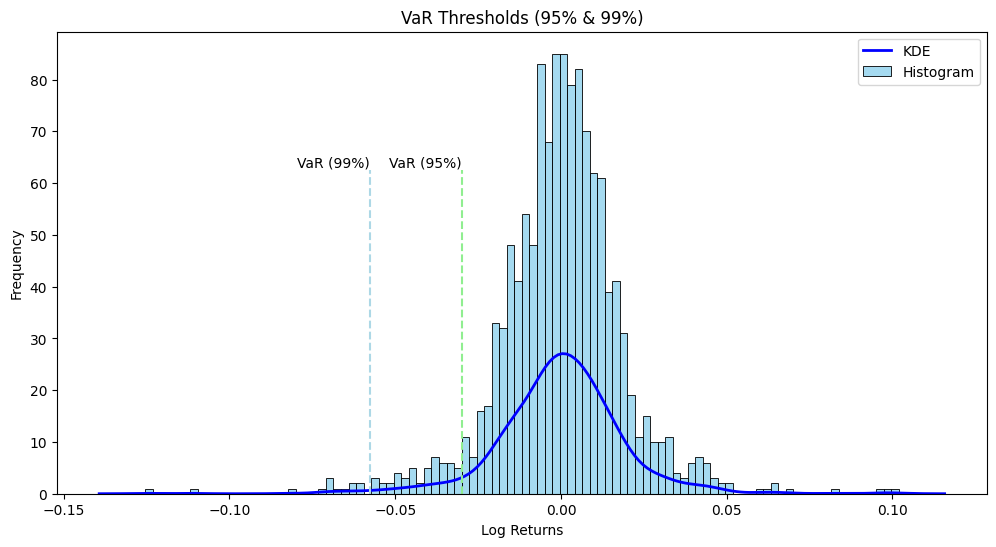

In [10]:
plt.figure(figsize=(12,6))

# Plot Histogram (without KDE)
sns.histplot(data['Log_Returns'], bins=100, kde=False, color='skyblue', label='Histogram')

# Plot KDE separately
sns.kdeplot(data['Log_Returns'], color='blue', linewidth=2, label='KDE')

# Get Y-axis limit for plotting lines shorter
ymin, ymax = plt.ylim()
line_height = ymax * 0.7  # make lines 70% of histogram height

# Draw shorter vertical lines (VaR)
plt.vlines(VaR_95, ymin=0, ymax=line_height, color='lightgreen', linestyle='--')
plt.vlines(VaR_99, ymin=0, ymax=line_height, color='lightblue', linestyle='--')

# Add text labels near the lines
plt.text(VaR_95, line_height, 'VaR (95%)', color='black', ha='right', va='bottom', fontsize=10, rotation=360)
plt.text(VaR_99, line_height, 'VaR (99%)', color='black', ha='right', va='bottom', fontsize=10, rotation=360)

plt.title('VaR Thresholds (95% & 99%)')
plt.xlabel('Log Returns')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Step 6: Compute CVaR (Expected Shortfall)

**CVaR at 95% Confidence**
- Could lose more than: If BASF.DE breaches the 95% VaR, the average loss beyond that point would be 4.790%**.
- Would not lose more than: In 95% of cases, losses are expected to be less than 2.996%, but if exceeded, the average loss will be 4.790% in that worst-case region.

---

**CVaR at 99% Confidence**
- Could lose more than: If the 99% VaR is breached, the average loss in that extreme 1% tail would be 7.523%.
- Would not lose more than: In 99% of cases, losses are expected to stay within 5.761%, but if breached, the average loss would be 7.523%.

In [11]:
# Step 6: Compute CVaR (Expected Shortfall)
CVaR_95 = sorted_returns[sorted_returns <= percentile_5].mean()
CVaR_99 = sorted_returns[sorted_returns <= percentile_1].mean()

CVaR_df = pd.DataFrame({
    'Confidence Level': ['95%', '99%'],
    'CVaR': [CVaR_95, CVaR_99]
})

# Add a column for Formatted VaR as Percentage
CVaR_df['CVaR (%)'] = (CVaR_df['CVaR'] * 100).round(4).astype(str) + '%'

CVaR_df

,Confidence Level,CVaR,CVaR (%)
0,95%,-0.047900,-4.79%
1,99%,-0.075228,-7.5228%


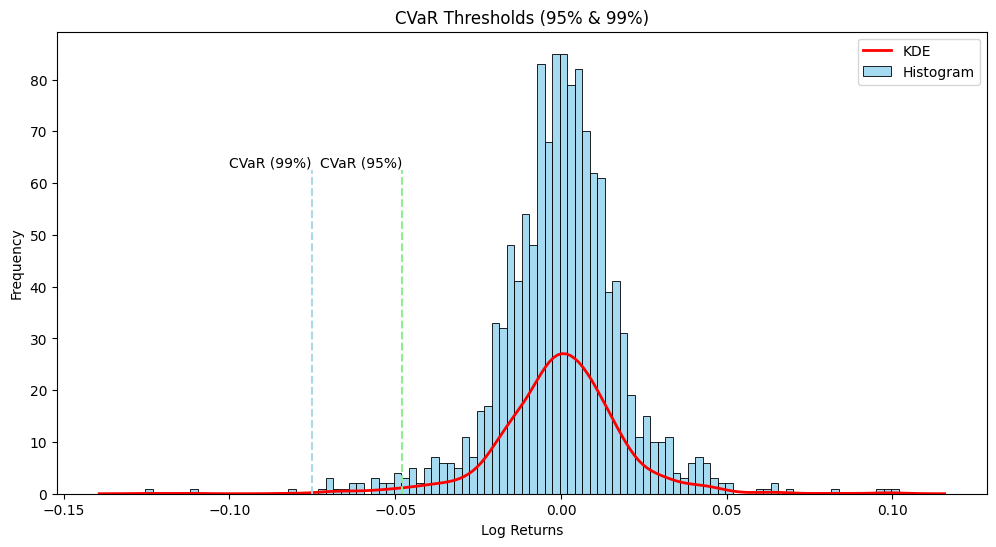

In [12]:
plt.figure(figsize=(12,6))

# Histogram (without KDE)
sns.histplot(data['Log_Returns'], bins=100, kde=False, color='skyblue', label='Histogram')

# KDE Plot
sns.kdeplot(data['Log_Returns'], color='red', linewidth=2, label='KDE')

# Y-axis limit for line heights
ymin, ymax = plt.ylim()
line_height = ymax * 0.7

# CVaR Lines
plt.vlines(CVaR_95, ymin=0, ymax=line_height, color='lightgreen', linestyle='--')
plt.vlines(CVaR_99, ymin=0, ymax=line_height, color='lightblue', linestyle='--')

# Text Labels
plt.text(CVaR_95, line_height, 'CVaR (95%)', color='black', ha='right', va='bottom', fontsize=10)
plt.text(CVaR_99, line_height, 'CVaR (99%)', color='black', ha='right', va='bottom', fontsize=10)

plt.title('CVaR Thresholds (95% & 99%)')
plt.xlabel('Log Returns')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Summary
At a 95% confidence level, BASF.DE is not expected to lose more than **2.996%** in a single day. However, in the worst 5% of cases where this threshold is breached, the average loss (CVaR) could be around **4.790%**. 

---
Similarly, at a 99% confidence level, daily losses are unlikely to exceed **5.761%**, but if they do, the expected average loss in such extreme scenarios would be approximately **7.523%**. 

---
This highlights that while VaR measures the worst expected loss within a confidence limit, CVaR gives a clearer picture of potential losses in extreme tail events.

In [13]:
# Summary DataFrame with Percentage Formatted VaR and CVaR
risk_metrics = pd.DataFrame({
    'Confidence Level': ['95%', '99%'],
    'VaR (Historical)': [VaR_95, VaR_99],
    'CVaR (Historical)': [CVaR_95, CVaR_99]
})

# Convert VaR and CVaR to percentages and format as strings with '%'
risk_metrics['VaR (Historical)'] = (risk_metrics['VaR (Historical)'] * 100).round(4).astype(str) + '%'
risk_metrics['CVaR (Historical)'] = (risk_metrics['CVaR (Historical)'] * 100).round(4).astype(str) + '%'

# Display the formatted DataFrame
risk_metrics

,Confidence Level,VaR (Historical),CVaR (Historical)
0,95%,-2.9958%,-4.79%
1,99%,-5.7607%,-7.5228%


## Parametric VaR & CVaR (Variance-Covariance Method) — Step-by-Step Guide


### Step 1: Collect Historical Daily Returns
- Use **daily log returns** of the asset (BASF.DE).
- Ensure the data is cleaned and free of missing values.

---

### Step 2: Calculate Mean and Standard Deviation of Returns
- Compute the **mean (μ)** and **standard deviation (σ)** of the daily log returns.
- For very short time horizons (like 1-day), the **mean is often assumed negligible ≈ 0**.

---

### Step 3: Choose Confidence Level
- Select the desired confidence level for VaR & CVaR:
  - 95% confidence level (α = 5%)
  - 99% confidence level (α = 1%)

---

### Step 4: Find Z-Score (Quantile of Standard Normal Distribution)
- Obtain the **Z-score** corresponding to the selected confidence level:
  - Z(95%) ≈ -1.645
  - Z(99%) ≈ -2.326

---

### Step 5: Compute Daily Parametric VaR
- Formula for **VaR (1-day horizon)**:
  $$\
  \text{VaR} = - ( \mu + Z \times \sigma )
  \$$
- **VaR is reported as a positive number** representing the maximum expected loss.

---

## Step 6: Compute Daily Parametric CVaR (Expected Shortfall)
- Formula for **CVaR (1-day horizon)** under normal distribution:
  $$
  \text{CVaR} = - \mu + \frac{ \sigma \times \phi(Z) }{1 - \alpha}
  \$$
  Where:
  - **φ(Z)** is the PDF (probability density function) of the standard normal at Z.
  - **α** is the tail probability (5% or 1%).

---

## Step 7: Scale VaR & CVaR for Multi-Day Horizons
- For a **T-day horizon**, scale the **standard deviation by √T**:
  $$\
  \sigma_T = \sigma \times \sqrt{T}
  \$$
- Recompute VaR and CVaR using this adjusted standard deviation.

---

## Summary Formulae:

| Metric             | Formula                                                   |
|--------------------|-----------------------------------------------------------|
| **VaR (T-day)**     | \(- Z \times \sigma \times \sqrt{T}\)                     |
| **CVaR (T-day)**    | \(\frac{ \sigma \times \sqrt{T} \times \phi(Z) }{ 1 - \alpha }\) |

---

## Key Assumptions:
- Returns are **normally distributed**.
- Returns are **independent and identically distributed (i.i.d.)**.
- No extreme events or skewed fat tails.

# PARAMETRIC

### Step 2: Calculate Mean and Standard Deviation of Daily Returns

In [34]:
# Step 2: Mean and Standard Deviation of Daily Returns
mu = data['Log_Returns'].mean()
sigma = data['Log_Returns'].std()

# Display in DataFrame
step2_df = pd.DataFrame({
    'Metric': ['Mean (μ)', 'Standard Deviation (σ)'],
    'Value': [mu, sigma]
})

print("\n Mean and Standard Deviation")
step2_df


 Mean and Standard Deviation


,Metric,Value
0,Mean (μ),-0.000119
1,Standard Deviation (σ),0.019240


### Step 3: Choose Confidence Levels

In [32]:
# Step 3: Confidence Levels (α)
confidence_levels = [0.95, 0.99]
alpha_95 = 1 - confidence_levels[0]
alpha_99 = 1 - confidence_levels[1]

# Display in DataFrame
step3_df = pd.DataFrame({
    'Confidence Level': ['95%', '99%'],
    'Alpha (Tail Probability)': [alpha_95, alpha_99]
})

print("\n Confidence Levels and Alpha")
step3_df


 Confidence Levels and Alpha


,Confidence Level,Alpha (Tail Probability)
0,95%,0.05
1,99%,0.01


### Step 4: Find Z-Scores (Quantiles of Standard Normal Distribution)

In [35]:
from scipy.stats import norm

# Step 4: Z-Scores
Z_95 = norm.ppf(alpha_95)
Z_99 = norm.ppf(alpha_99)

# Display in DataFrame
step4_df = pd.DataFrame({
    'Confidence Level': ['95%', '99%'],
    'Z-Score': [Z_95, Z_99]
})

print("\n Z-Scores for Confidence Levels:")
step4_df


 Z-Scores for Confidence Levels:


,Confidence Level,Z-Score
0,95%,-1.644854
1,99%,-2.326348


### Step 5: Compute Daily Parametric VaR (1-Day Horizon)

In [36]:
# Step 5: Compute Daily Parametric VaR
VaR_95_day = - (mu + Z_95 * sigma)
VaR_99_day = - (mu + Z_99 * sigma)

# Display in DataFrame
step5_df = pd.DataFrame({
    'Confidence Level': ['95%', '99%'],
    '1-Day Parametric VaR': [VaR_95_day, VaR_99_day]
})

print("\n 1-Day Parametric VaR:")
step5_df


 1-Day Parametric VaR:


,Confidence Level,1-Day Parametric VaR
0,95%,0.031767
1,99%,0.044879


### Step 6: Daily Parametric CVaR (Expected Shortfall)

In [41]:
# Step 6: Compute CVaR
phi_95 = norm.pdf(Z_95)
phi_99 = norm.pdf(Z_99)

CVaR_95_day = - mu + (sigma * phi_95) / alpha_95
CVaR_99_day = - mu + (sigma * phi_99) / alpha_99

# Display in DataFrame
step6_df = pd.DataFrame({
    'Confidence Level': ['95%', '99%'],
    '1-Day Parametric CVaR': [CVaR_95_day, CVaR_99_day]
})

print("\n 1-Day Parametric CVaR (Expected Shortfall)")
step6_df


 1-Day Parametric CVaR (Expected Shortfall)


,Confidence Level,1-Day Parametric CVaR
0,95%,0.039807
1,99%,0.051399


### Step 7: Multi-Day Scaling (e.g., T = 10 days)

In [39]:
# Step 7: Multi-Day Scaling (e.g., T = 10 days)
T = 10
sigma_T = sigma * np.sqrt(T)

# Multi-Day VaR
VaR_95_multi = - (mu * T + Z_95 * sigma_T)
VaR_99_multi = - (mu * T + Z_99 * sigma_T)

# Multi-Day CVaR
CVaR_95_multi = - mu * T + (sigma_T * phi_95) / alpha_95
CVaR_99_multi = - mu * T + (sigma_T * phi_99) / alpha_99

# Display in DataFrame
step7_df = pd.DataFrame({
    'Confidence Level': ['95%', '99%'],
    f'{T}-Day Parametric VaR': [VaR_95_multi, VaR_99_multi],
    f'{T}-Day Parametric CVaR': [CVaR_95_multi, CVaR_99_multi]
})

print(f"\n {T}-Day Parametric VaR and CVaR:")
step7_df


 10-Day Parametric VaR and CVaR:


,Confidence Level,10-Day Parametric VaR,10-Day Parametric CVaR
0,95%,0.101272,0.126696
1,99%,0.142736,0.163354
